# Improving Fraud Detection for Cost Minimization

This notebook is mainly based on *Robin Teuwens' notebook on Fraud Detection as a Cost Optimization Problem*: https://www.kaggle.com/robinteuwens/precision-vs-recall-optimizing-fraud-costs

Even if the name of his notebook has changed, hopefully the content remains the same. This is what makes his notebook original and more interesting than classic notebooks on fraud detection. Indeed, Robin deals with the credit card fraud dataset as we deal with such data most of the time in the business world: *we want to minimize costs and maximize profits*.

We refer to Robin Teuwens' notebook cited above for the formulation of the business problem.
We assume the reader is already knowledgeable in dealing with imbalanced data and usual fraud detection algorithms. Finally, we remind **fraud represents 0.173% of the studied dataset**.

The aim of this notebook is to *improve Robin's cost minimization baseline* by studying new sampling methods, discussing the choice of the optimization metric and trying usually better performing models for fraud detection.



In [1]:
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # graphs
import seaborn as sns; sns.set()   # pretty visualisations

# load the dataset
df = pd.read_csv('../input/creditcard.csv')

In [2]:
# manual paramaters
TEST_RATIO = 0.2
RANDOM_SEED = 777

In [3]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


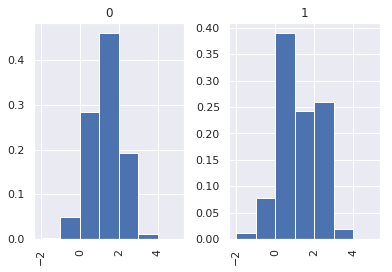

In [4]:
# add calculated field
# add a negligible amount to avoid a RuntimeWarning: divide by zero encountered in log10
df['log10_amount'] = np.log10(df.amount + 0.00001)

# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']]
    + ['log10_amount', 'label']
]

# plot distribution 
df.log10_amount.hist(by=df.label, bins=7, range=(-2,5), density=True);

# Baseline Model
Let's blindly apply a **logistic regression model** for us as a **benchmark** for future iterations. <br>
We should be able to get away with this reasonably well, since the dataset has been preprocessed already (anonymised through PCA, it seems).

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# splitting our label classification from our dataset and dropping redundant columns
features = df.drop(['time', 'amount', 'label'], axis=1)
labels = df.label
column_names = list(features.columns)

X_train, X_test, y_train, y_test = train_test_split(
    features.values, 
    labels.values,
    shuffle=True,
    stratify=labels.values,
    test_size=TEST_RATIO,
    random_state=RANDOM_SEED
) 

In [7]:
# Bundling the costs in a dictionary for use in our functions: see Robin Teuwens' notebook
avg_fraud_cost = round(np.mean(df.loc[df.label==1].amount.values), 1)
avg_monitoring_cost = 1.7371

costs = {
    'avg_fraud_cost': avg_fraud_cost,
    'avg_monitoring_cost': avg_monitoring_cost,
    'test_ratio': TEST_RATIO
}    

def cost_function(fp, fn, costs):
    return fp * costs['avg_monitoring_cost'] + fn * costs['avg_fraud_cost']

def misclassification_cost(classification_matrix, costs):
    false_negatives = classification_matrix[1,0]
    false_positives = classification_matrix[0,1]

    cost = cost_function(fp=false_positives, fn=false_negatives, costs=costs)
    
    validation_cost = f'\nThe misclassification cost on this validation set \
({TEST_RATIO * 100}% of data) is € {cost:,.2f}'
    estimation_cost = f'\nExtrapolated to an entire day\'s worth of transactions \
(/{TEST_RATIO}/2 days), we get ~ € {cost/TEST_RATIO/2:,.2f}'
    
    return validation_cost + estimation_cost

def evaluation_report(ground_truth, predicted, costs):
    report = classification_report(ground_truth, predicted)
    conf_matrix = confusion_matrix(ground_truth, predicted)
    cost = misclassification_cost(conf_matrix, costs)
    
    return f'{report}\n{conf_matrix}\n{cost}'

### Reading a confusion matrix
To keep this already lengthy notebook a bit more comptact, we'll be printing out the confusion matrices.
That means they'll be unlabeled, though, so here's a quick refresher.
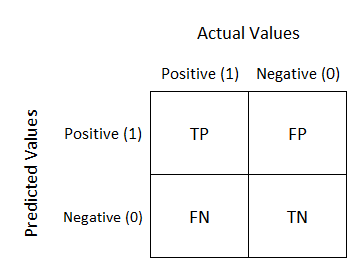

In [8]:
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    # fit & predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # evaluate our model
    print(evaluation_report(y_test, y_pred, costs))

In [9]:
# lbfgs will be the new default solver, specified as argument to supress warning message

# evaluate our model
evaluate_classifier(LogisticRegression(solver='lbfgs'), X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.53      0.67        98

    accuracy                           1.00     56962
   macro avg       0.96      0.77      0.84     56962
weighted avg       1.00      1.00      1.00     56962

[[56859     5]
 [   46    52]]

The misclassification cost on this validation set (20.0% of data) is € 5,629.89
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 14,074.71


It's already much better than doing nothing... but **recall isn't great** at this point. Of course, we haven't set up the model to prioritise it.
We can attribute **different weights to the classes** to solve for this.

>https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html    
>The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). <br>


In [10]:
# evaluate our model
evaluate_classifier(
    LogisticRegression(solver='lbfgs', class_weight='balanced'), X_train, y_train, X_test, y_test
)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.96      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.97      0.55     56962
weighted avg       1.00      0.98      0.99     56962

[[55501  1363]
 [    4    94]]

The misclassification cost on this validation set (20.0% of data) is € 2,856.47
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 7,141.17


Better recall, as we're catching more fraud, but we're losing out on the surplus due to a slew of transactions we now have to investigate.

## Custom class weight
Let's apply the same method, but pass onto the model the cost ratio we have calculated prior.

In [11]:
# custom weight
fraud_weight = round(avg_fraud_cost / avg_monitoring_cost, 1)
print(f'The weight we\'ve attributed to fraud is: {fraud_weight} to 1\n')

# instantiate regressor
Lr_Weight = LogisticRegression(solver='lbfgs', class_weight={
    1: fraud_weight,
    0: 1
})

# evaluate our model
evaluate_classifier(Lr_Weight, X_train, y_train, X_test, y_test)

The weight we've attributed to fraud is: 70.3 to 1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.45      0.90      0.60        98

    accuracy                           1.00     56962
   macro avg       0.72      0.95      0.80     56962
weighted avg       1.00      1.00      1.00     56962

[[56756   108]
 [   10    88]]

The misclassification cost on this validation set (20.0% of data) is € 1,409.61
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 3,524.02


Clearly, this solves our cost function much better. We have reduced the costs associated with fraud detection by almost an order of magnitude.

Although we have a couple of extra cases of fraud slipping through, we make up for it by saving tremendously on monitoring costs.

**It's now up to us to improve the model** across the board. 

# New in this notebook: Gradient boosted models

Gradient boosted models are known for their performance on tabular data. Let's try these models and see if they outperform logistic regression.

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [13]:
for clf in [
    XGBClassifier(scale_pos_weight=fraud_weight),
    LGBMClassifier(class_weight={0: 1, 1: fraud_weight}),
]:
    # evaluate our model
    print(clf.__class__.__name__)
    evaluate_classifier(clf, X_train, y_train, X_test, y_test)

XGBClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.89      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.94      0.86     56962
weighted avg       1.00      1.00      1.00     56962

[[56805    59]
 [   11    87]]

The misclassification cost on this validation set (20.0% of data) is € 1,446.69
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 3,616.72
LGBMClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56856     8]
 [   19    79]]

The misclassification cost on this validation set (20.0% of data) is € 2,335.70
Extr

Neither XGBoost nor LGBM achieve better performance than Logistic Regression on this dataset... *For now!* **Let's add a sampling method to see if it changes the ranking of these algorithms**.

# Sampling methods

## SMOTE

The *Synthetic Minority Oversampling TEchnique* is a promising way to feed the model more fraud data, albeit artificially. <br>
A great blog post on the topic: http://rikunert.com/SMOTE_explained

## New in this notebook: ADASYN

The *Adaptive Synthetic Sampling Method for Imbalanced Data* is another sampling method which generates more synthetic data for minority class (https://ieeexplore.ieee.org/document/4633969). Here is a *Medium article* which concisely explains ADASYN: https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa

In [14]:
def plot_data(X, y, title='', name="graph.png"):
    plt.figure(figsize=(16,8));
    
    # clean
    plt.scatter(
        X[y == 0, 12], X[y == 0, 11], 
        label='clean', 
        alpha=0.2, 
        linewidth=0.05, 
        color='#9db68c' # green
    );
    
    # fraud
    plt.scatter(
        X[y == 1, 12], X[y == 1, 11],
        label='fraud',
        alpha=0.5,
        linewidth=0.05, 
        color='#db5e5e' # red
    );
    
    plt.title(title);
    plt.legend(loc='best');
    plt.savefig(name);

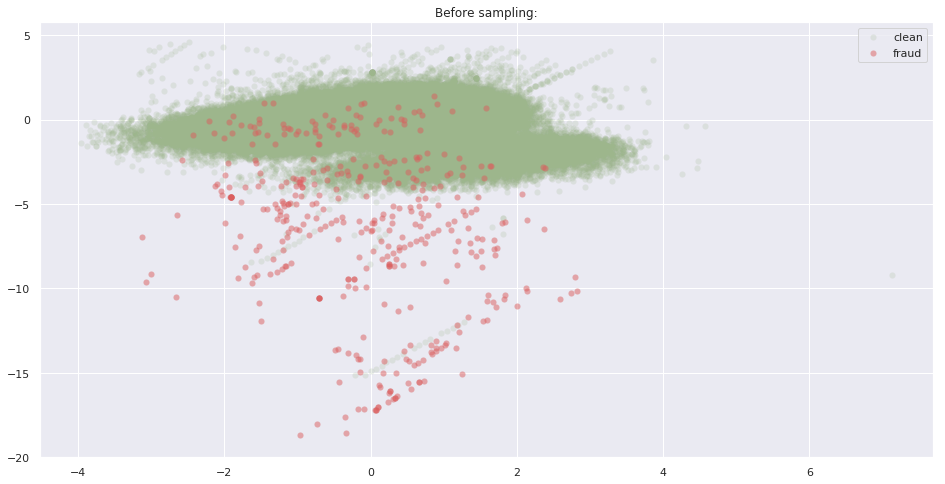

In [15]:
plot_data(X_train, y_train,
          title='Before sampling:',
          name='before_sampling.png')

### Avoid data leakage
Note that we **resample only the training set**, so as to avoid leaking test data to the new model trained on the oversampled set.
After all, **oversampling changes the shape of the dataset, so future train_test_split() wouldn't produce the same distinctly isolated sets**, even with the same random_state parameter. We definitely want to avoid training on data we then test on.

In [16]:
fraud_in_train_set = y_train.sum()
print(f'There are {fraud_in_train_set} fraud transactions in the training set')

There are 394 fraud transactions in the training set


In [17]:
def sample_data(sampler, X_train, y_train):
    # Define the resampling method
    resampler = sampler(
        random_state=RANDOM_SEED,

        # synthetically create a multiple of fraud observations currently in the training set
        sampling_strategy={1: int(fraud_in_train_set * fraud_weight)}
    )

    # Create the resampled feature set
    X_train_resampled, y_train_resampled = resampler.fit_sample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

There are now 27,698 fraud transactions in the oversampled training set


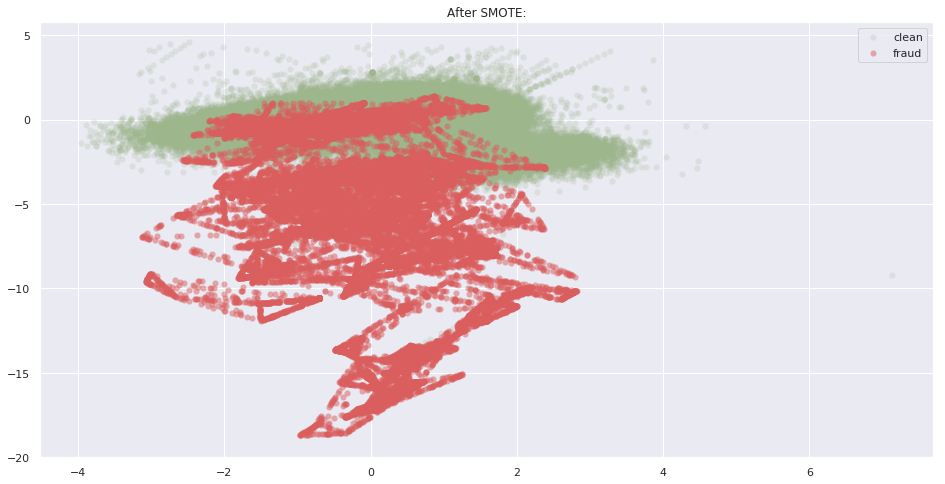

There are now 27,703 fraud transactions in the oversampled training set


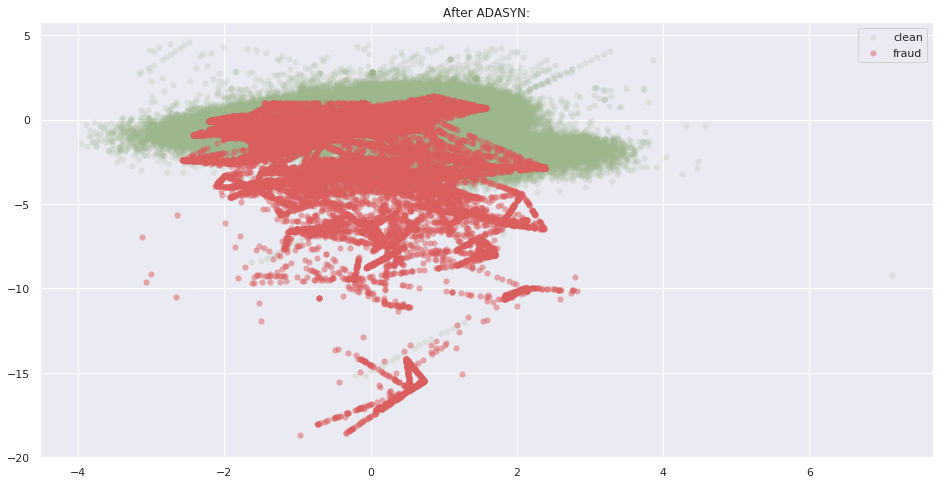

In [18]:
from imblearn.over_sampling import ADASYN, SMOTE

for sampler in [SMOTE, ADASYN]:
    # Create the resampled feature set
    X_train_resampled, y_train_resampled = sample_data(sampler, X_train, y_train)

    print(f'There are now {y_train_resampled.sum():,} fraud transactions in the oversampled training set')

    plot_data(X_train_resampled, y_train_resampled,
              title='After {}:'.format(sampler.__name__),
              name='after_{}.png'.format(sampler.__name__))
    
    plt.show()

# Effect of sampling on performance

In [19]:
for sampler in [SMOTE, ADASYN]:
    # Create the resampled feature set
    X_train_resampled, y_train_resampled = sample_data(sampler, X_train, y_train)

    # evaluate our model
    evaluate_classifier(
        LogisticRegression(solver='lbfgs'), X_train_resampled, y_train_resampled, X_test, y_test
    )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.91      0.58        98

    accuracy                           1.00     56962
   macro avg       0.71      0.95      0.79     56962
weighted avg       1.00      1.00      1.00     56962

[[56744   120]
 [    9    89]]

The misclassification cost on this validation set (20.0% of data) is € 1,308.25
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 3,270.63
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.94      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.96      0.61     56962
weighted avg       1.00      0.99      0.99     56962

[[56236   628]
 [    6    92]]

The misclassification cost on this validation set (20.0% of data) is € 1,824.10
Extrapolated to an entire day's w

The results are similar. We shouldn't be overly surprised by this, of course. After all, **SMOTE was configured to multiply the amount of fraud samples we already had by the fraud_weight we had found as a result of our cost comparison**.

It does seem that **SMOTE slightly outperforms a simple configuration of the LogisticRegression's class_weight parameter when it comes to catching fraud**. The synthetic imputation allowed our model to generalize just a little bit better than simply training on the same data points over a multiple of iterations. We would have to cross-validate to check this.

# Finetuning Thresholds
To further improve, we can look at the computed class **probabilities** of a classifier and **shift the threshold** at which we deem a case to be fraud. This allows us to further tune the **cost-efficiency** of our model.

In [20]:
def cost_per_threshold(clf, sampler, X_train, y_train, X_test, y_test, costs):
    """ return four lists:
            1) list of thresholds (defined in this function) 
            2) count of false negatives (uncaught fraud)
            3) count of false positives (overreported transactions)
            4) total cost per threshold iteration
    """
    
    # Create the resampled feature set
    X_train_resampled, y_train_resampled = sample_data(sampler, X_train, y_train)

    # training
    clf.fit(X_train_resampled, y_train_resampled)
    
    # lists to be passed to plot
    thresholds = np.arange(start=0.05, stop=1, step=0.025)
    fn, fp = [], []

    # looping through thresholds to plot cost curve
    for threshold in thresholds:

        # custom threshold
        y_pred = (clf.predict_proba(X_test)[:,1] > threshold).astype(int)

        # extracting performance indicators
        false_positives = confusion_matrix(y_test, y_pred)[0,1]
        false_negatives = confusion_matrix(y_test, y_pred)[1,0]

        # add to lists
        fp.append(false_positives)
        fn.append(false_negatives)

    # convert to numpy arrays
    fp = np.asarray(fp)
    fn = np.asarray(fn)
    c = cost_function(fp, fn, costs)
    
    # return values
    return thresholds, fp, fn, c

In [21]:
def plot_misclassification(thresholds, fp, fn, c):
    
    # two y-axes sharing the same plot
    fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    """ LEFT PLOT """
    left.title.set_text('Misclassification Counts')

    # 1st y-axis
    color = 'tab:orange'
    left.set_xlabel('threshold')
    left.set_ylabel('false positives', color=color)
    left.plot(thresholds, fp, color=color)
    left.tick_params(axis='y', labelcolor=color)

    # 2nd y-axis
    left_2nd_y = left.twinx() # share the same x-axis
    color = 'tab:red'
    left_2nd_y.set_ylabel('false negatives', color=color) 
    left_2nd_y.plot(thresholds, fn, color=color)
    left_2nd_y.tick_params(axis='y', labelcolor=color)


    """ RIGHT PLOT """
    right .title.set_text('Misclassification Costs')

    # plotting costs
    color = 'tab:blue'
    right.set_xlabel('threshold')
    right.set_ylabel('total (€)', color=color)
    right.plot(thresholds, c, color=color)
    right.tick_params(axis='y', labelcolor=color)

    
    """ ANNOTATE """
    # calculate minimum cost threshold
    optimal_threshold = min(zip(thresholds, c), key=lambda t: t[1])
    optimal_threshold_index = np.where(thresholds==optimal_threshold[0])[0] 
    optimal_threshold_fp = fp[optimal_threshold_index]
    optimal_threshold_fn = fn[optimal_threshold_index]
    
    right.plot(*optimal_threshold, 'go');
    
    # display cost optimum
    print(f'The cost minimum occurs at threshold {optimal_threshold[0]:.3f}, where the misclassification are as follows')
    print(f'    False positives: {optimal_threshold_fp}')
    print(f'    False negatives: {optimal_threshold_fn}')
    print('')
    print(f'Misclassification costs on test sample: {optimal_threshold[1]:,.2f}')
    print(f'Extrapolated daily cost: {optimal_threshold[1]/TEST_RATIO/2:,.2f}')
    
    """ DISPLAY """
    # prevent clipping and overlap between graphs
    fig.tight_layout()  
    plt.show();

The cost minimum occurs at threshold 0.425, where the misclassification are as follows
    False positives: [169]
    False negatives: [8]

Misclassification costs on test sample: 1,271.17
Extrapolated daily cost: 3,177.92


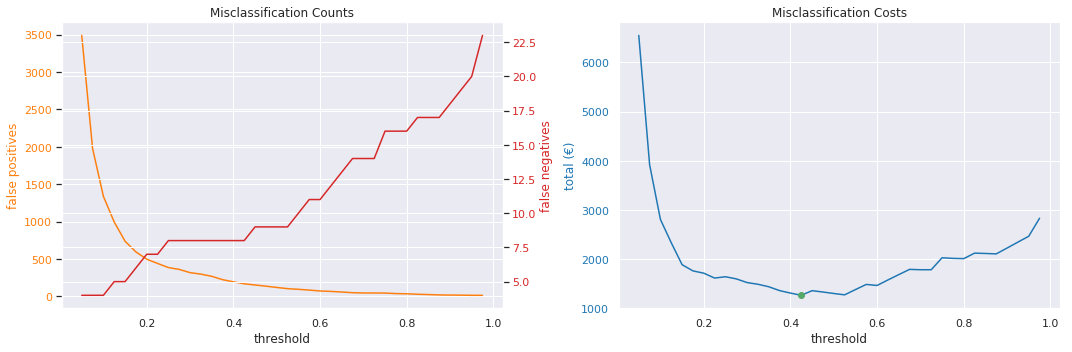

In [22]:
# compute results at each threshold level
thresholds, fp, fn, c = cost_per_threshold(
    LogisticRegression(solver='lbfgs'), SMOTE, X_train, y_train, X_test, y_test, costs
)

# visualise them
plot_misclassification(thresholds, fp, fn, c)

# New in this notebook: Cross-comparison of classifiers and sampling methods

We saw above that neither XGBoost nor LGBM performed better than Logistic Regression without sampling, and that ADASYN did not perform better than SMOTE for Logistic Regression. Would another combination work better?

LogisticRegression SMOTE
The cost minimum occurs at threshold 0.425, where the misclassification are as follows
    False positives: [169]
    False negatives: [8]

Misclassification costs on test sample: 1,271.17
Extrapolated daily cost: 3,177.92


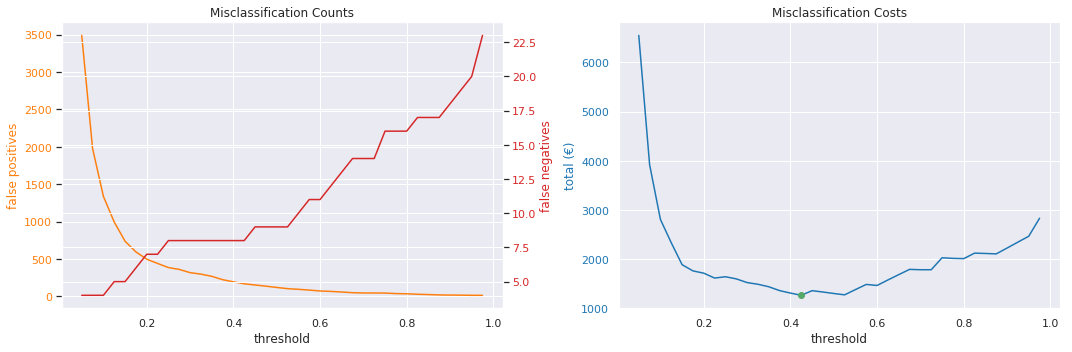

LogisticRegression ADASYN
The cost minimum occurs at threshold 0.800, where the misclassification are as follows
    False positives: [211]
    False negatives: [8]

Misclassification costs on test sample: 1,344.13
Extrapolated daily cost: 3,360.32


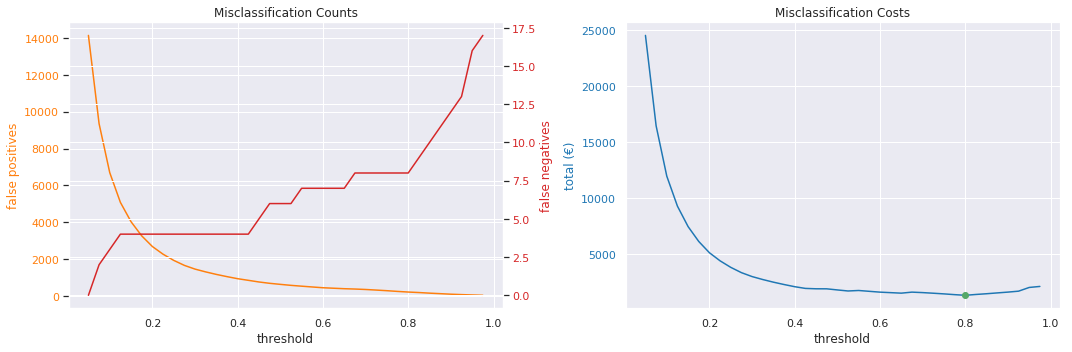

XGBClassifier SMOTE
The cost minimum occurs at threshold 0.500, where the misclassification are as follows
    False positives: [68]
    False negatives: [9]

Misclassification costs on test sample: 1,217.92
Extrapolated daily cost: 3,044.81


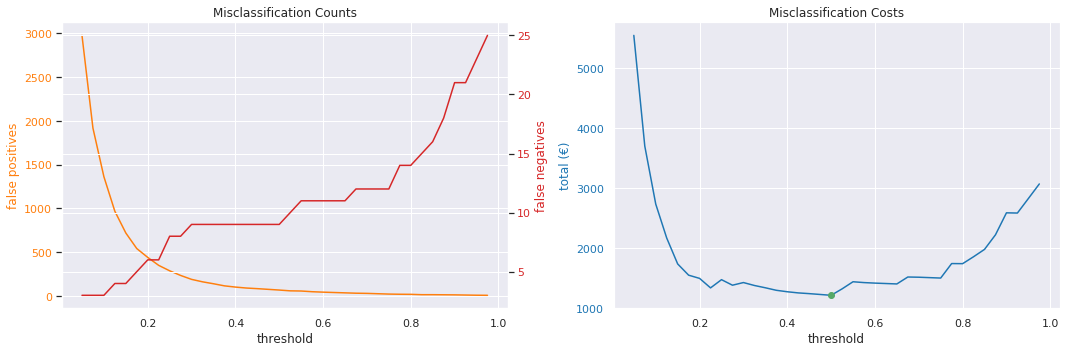

XGBClassifier ADASYN
The cost minimum occurs at threshold 0.550, where the misclassification are as follows
    False positives: [232]
    False negatives: [6]

Misclassification costs on test sample: 1,136.21
Extrapolated daily cost: 2,840.52


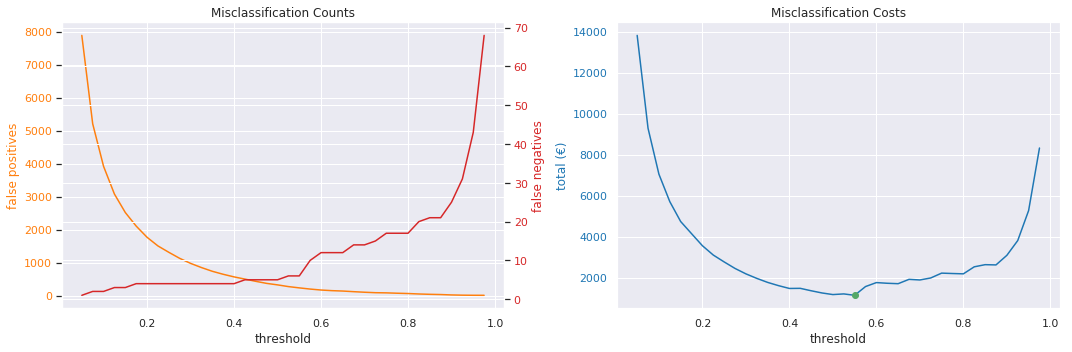

LGBMClassifier SMOTE
The cost minimum occurs at threshold 0.075, where the misclassification are as follows
    False positives: [183]
    False negatives: [7]

Misclassification costs on test sample: 1,173.29
Extrapolated daily cost: 2,933.22


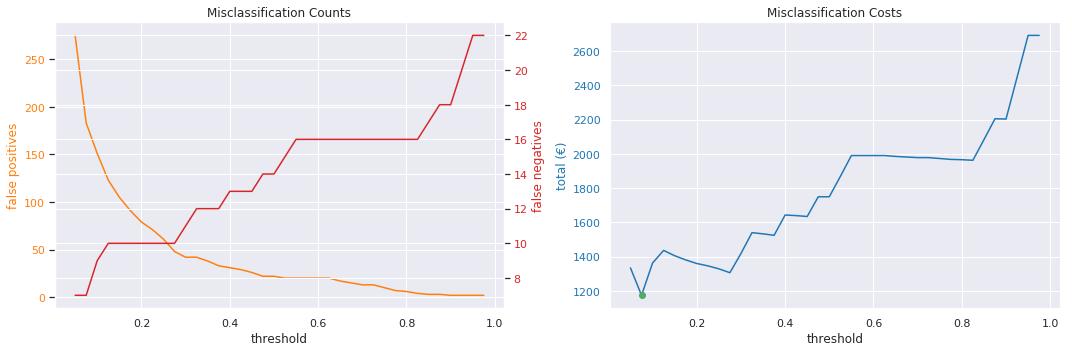

LGBMClassifier ADASYN
The cost minimum occurs at threshold 0.150, where the misclassification are as follows
    False positives: [195]
    False negatives: [5]

Misclassification costs on test sample: 949.73
Extrapolated daily cost: 2,374.34


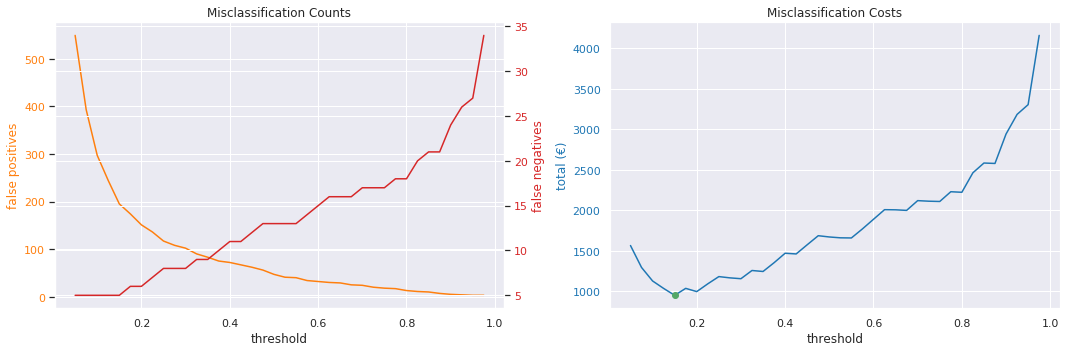

In [23]:
for clf in [
    LogisticRegression(solver='lbfgs'),
    XGBClassifier(),
    LGBMClassifier()
]:
    for sampler in [SMOTE, ADASYN]:
        # compute results at each threshold level
        print(clf.__class__.__name__, sampler.__name__)
        thresholds, fp, fn, c = cost_per_threshold(clf, sampler, X_train, y_train, X_test, y_test, costs)

        # visualise them
        plot_misclassification(thresholds, fp, fn, c)

Due to the high cost associated to false negatives, we can see that **gradient boosted classifiers perform much better on the sampled data**! We note that ADASYN becomes a better sampling methods for XGBoost and LGBM classifiers. From the Logistic Regression after SMOTE to the LGBM after ADASYN, **we reduced the misclassification costs by 25.29%** !

False negatives / False positives:

|   #    | LogReg   | XGBoost  | LGBM     |
|--------|----------|----------|----------|
| SMOTE  | 8 / 169  | 9 / 68   | 7 / 183  |
| ADASYN | 8 / 211  | 6 / 232  | 5 / 195  |


Misclassification costs:

| $      | LogReg   | XGBoost  | LGBM     |
|--------|----------|----------|----------|
| SMOTE  | 1,271.17 | 1,217.92 | 1,173.29 |
| ADASYN | 1,344.13 | 1,136.21 | 949.73   |




# Conclusion

The purpose of this notebook is twofold:

1. highlight the fact that **choosing the right performance metric** is important when 
    * **classes are unbalanced** 
    * the **consequences of misclassification (type I & II) are asymmetrical**
    
    
2. to show that **machine learning algorithms can be highly effective at calibrating the rate of false negatives vs false positives, thereby optimizing a cost function** - more so than rule-based systems.

If you found this kernel helpful, or appreciated the alternative angle of approaching this dataset from a business perspective, please upvote it.
